## Unsupervised Behavioral Phenotyping with 3D Skeletal Pose
Joshua Wu

Duke University Biomedical Engineering

[Timothy Dunn Lab](https://www.tdunnlab.org/)

11 June, 2024

Neurodegenerative diseases (like Parkinson's) are characterized by a wide variety of behavioral defects or movement deficits. However, behavior and movement have historically been difficult to quantify and measure. Recent developments in hardware and machine learning have enabled more objective behavioral metrics by providing continuous 3D measurements of naturalistic animal behavior through multi-view videos. These new modalities of data offer a means by which we can comprehensively characterize behavioral phenotypes of neural (dys)-function. We present `neuroposelib` to establish an open-source API with easy access to machine learning methods for the analysis of 3D pose sequences.

This notebook implements a Python version of [CAPTURE (Marshall, 2020)](https://www.cell.com/neuron/fulltext/S0896-6273(20)30894-1?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627320308941%3Fshowall%3Dtrue), which was based on earlier work [MotionMapper (Berman, 2014)](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2014.0672) for the analysis of behavioral data.

To follow this notebook, please download the contents of the [demo dataset](https://duke.box.com/v/demo-mouse-poses) into the `/neuroposelib/tutorials/demo_mouse/` directory.

First, we import the necessary modules.

In [1]:
from neuroposelib import read
from neuroposelib import vis
import numpy as np
import time
from IPython.display import Video
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

Load pose predictions, keypoint connectivity information, and metadata.

In [2]:
analysis_key = "tutorial"
config = read.config("../configs/" + analysis_key + ".yaml")

pose, ids = read.pose_h5(config["data_path"] + "demo_mouse.h5")

connectivity = read.connectivity_config(
    path=config["skeleton_path"]
)

meta, meta_by_frame = read.meta(config["data_path"] + "demo_meta.csv", id=ids)

Path(config["out_path"]).mkdir(parents=True, exist_ok=True)

`pose` shape (# frames x # keypoints x 3 coordinates).

In [3]:
print("Pose shape (# frames x # keypoints x 3 coordinates): ")
print(pose.shape)

Pose shape (# frames x # keypoints x 3 coordinates): 
(648000, 18, 3)


`meta` contains categorical information on recording sessions in `pose`. Here, we have loaded in two sessions. Each frame of the `pose` has a session id label in `ids`.

In [4]:
print(meta)
print("\n" + str(ids))

   id AnimalID     Sex       Strain Condition                           Path
0   0       A0    Male  Adora2a-Cre  Baseline  ./demo_mouse/demo_mouse_0.mat
1   1       A1  Female  Adora2a-Cre  Baseline  ./demo_mouse/demo_mouse_1.mat

[0 0 0 ... 1 1 1]


`connectivity` contains key information indicating keypoint labels, connectivity, etc.

In [5]:
print("keypoint labels")
print(connectivity.joint_names)
print("\n Keypoint connections")
print(connectivity.links)

keypoint labels
['Snout', 'EarR', 'EarL', 'SpineF', 'SpineM', 'Tail_base', 'ForepawR', 'WristR', 'ElbowR', 'ForepawL', 'WristL', 'ElbowL', 'HindpawR', 'AnkleR', 'KneeR', 'HindpawL', 'AnkleL', 'KneeL']

 Keypoint connections
[[ 0  1]
 [ 1  3]
 [ 0  2]
 [ 2  3]
 [ 2  1]
 [ 0  3]
 [ 4  3]
 [ 5  4]
 [ 6  7]
 [ 7  8]
 [ 8  3]
 [ 9 10]
 [10 11]
 [11  3]
 [12 13]
 [13 14]
 [14  5]
 [15 16]
 [16 17]
 [17  5]]


To see more details on how to set up these files. See the tutorial in `set_up.ipynb`.

Let's plot 150 frames from each session.

In [6]:
vis.pose.arena3D(
    pose,
    connectivity,
    frames=[1000, 500000],
    N_FRAMES=150,
    dpi=100,
    VID_NAME="raw.mp4",
    SAVE_ROOT=config["out_path"],
)

Video(config["out_path"] + "vis_raw.mp4", width=600, height=600)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:12<00:00, 12.00it/s]


Skeletons across sessions may not be aligned worldviews. The following code will estimate the floor plane for each session, and rotate to the x-y plane.

In [7]:
from neuroposelib import preprocess

pose_aligned = preprocess.align_floor_by_id(pose=pose, ids=ids, foot_id=12, head_id=0)

vis.pose.arena3D(
    pose_aligned,
    connectivity,
    frames=[1000, 500000],
    N_FRAMES=150,
    dpi=100,
    VID_NAME="aligned.mp4",
    SAVE_ROOT=config["out_path"],
)

Video(config["out_path"] + "vis_aligned.mp4", width=600, height=600)

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting and rotating the floor for each video to alignment ... 


 50%|█████     | 1/2 [00:00<00:00,  2.20it/s]

Fitting and rotating the floor for each video to alignment ... 


100%|██████████| 150/150 [00:12<00:00, 12.31it/s]


You can use the following code to save the new aligned poses for easy access later.

In [8]:
from neuroposelib import write

# write.pose_h5(pose_aligned, ids, config["data_path"] + "pose_aligned.h5")

For this analysis, we would like to prevent divergence of behavioral representations due to global position. Thus, we will generate an egocentric representation of pose for downstream feature calculation. 

Here, we center the mid-spine to $(0,0,0)$, and rotate the front-spine to the $x+$ direction.

In [9]:
# Provide the mid-spine and the mid-spine -> front-spine indices.
pose = preprocess.rotate_spine(preprocess.center_spine(pose_aligned, keypt_idx=4), keypt_idx=[4, 3])

vis.pose.arena3D(
    pose,
    connectivity,
    frames=[50000],
    N_FRAMES=150,
    dpi=100,
    VID_NAME="centered.mp4",
    SAVE_ROOT=config["out_path"],
)

Video(config["out_path"] + "vis_centered.mp4", width=600, height=600)

Centering poses to mid spine ...
Rotating spine to xz plane ... 


100%|██████████| 150/150 [00:08<00:00, 17.47it/s]


In this package, we provide functionality for easily calculating features of interest. 

Using this centered and spine-locked pose transformation, we can calculate relative velocities of all keypoints. We leave out the mid spine since it is centered.

In [10]:
from neuroposelib import features

# # Getting relative velocities
# rel_vel, rel_vel_labels = features.get_velocities(
#     pose,
#     ids,
#     connectivity.joint_names,
#     joints=np.delete(np.arange(18), 4),
#     widths=[5, 11, 51],
# )

You can also calculate joint angles of interest as specified in `skeletons.py`.

In [11]:
print(connectivity.angles)

[[ 0  1  3]
 [ 0  2  3]
 [ 0  3  4]
 [ 1  3  4]
 [ 2  3  4]
 [ 3  4  5]
 [ 1  3  8]
 [ 2  3  8]
 [ 0  3  8]
 [ 3  8  7]
 [ 8  7  6]
 [ 1  3 11]
 [ 2  3 11]
 [ 0  3 11]
 [ 3 11 10]
 [11 10  9]
 [ 4  5 14]
 [ 5 14 13]
 [14 13 12]
 [ 4  5 17]
 [ 5 17 16]
 [17 16 15]
 [ 0  3  6]
 [ 0  3  7]
 [ 0  3  9]
 [ 0  3 10]
 [ 4  5 12]
 [ 4  5 13]
 [ 4  5 15]
 [ 4  5 16]]


In [12]:
# Calculating joint angles
angles, angle_labels = features.get_angles(pose, connectivity.angles)

Calculating joint angles ... 


100%|██████████| 30/30 [00:01<00:00, 23.86it/s]


These velocity and angle calculations are just for demonstration, we will not use velocities or angles for the analysis in this tutorial.

We will just rearrange egocentric x, y, z coordinates of each keypoint into its own set of features. This code does not calculate anything - it just reshapes the pose and generates labels for each feature.

In [13]:
# Reshape pose to get egocentric pose features
ego_pose, labels = features.get_ego_pose(pose, connectivity.joint_names)

# Clear some memory
del angles, angle_labels, #rel_vel, rel_vel_labels

Reformatting pose to egocentric pose features ... 


Write features to or read features from `.h5` file.

In [14]:
# Write
# write.features_h5(features, labels, path=config["out_path"] + "postural_feats.h5")

# Read
# features, labels = read.features_h5(path=config["out_path"] + "postural_feats.h5")

It's now time for principal component analysis (PCA). PCA is a dimensionality reduction technique which generates orthogonal axes of high variance upon which to project our data. There are many implementations of PCA, but we will use Facebook's Fast Randomized PCA package (`fbpca`), which is significantly faster than most other implementations.

In [15]:
t = time.time()
pc_feats, pc_labels = features.pca(
    ego_pose, labels, categories=["ego_euc"], n_pcs=5, method="fbpca"
)
print("PCA time: " + str(time.time() - t))

del ego_pose, labels

Calculating principal components ... 


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

PCA time: 1.2112741470336914


Although velocities are calculated over rolling windows, the featurization we have so far still lacks the ability to capture complex temporal signals.

To address this, we can leverage the frequency domain through a Morlet wavelet transformation.

Let's see first what a Morlet wavelet looks like.

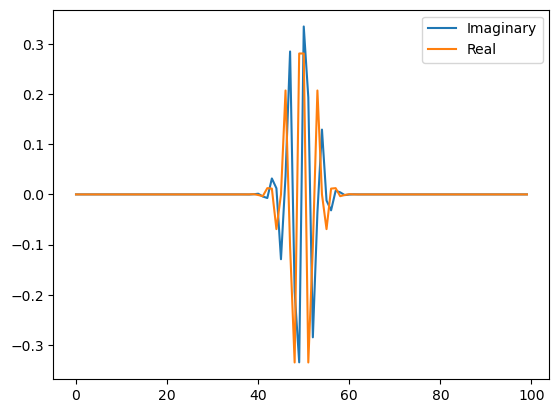

In [16]:
from scipy import signal
M = 100
w0 = 5
s = w0*90/(2*np.pi*25)
morlet_wavelet = signal.morlet2(M, s, w0)
plt.plot(morlet_wavelet.imag, label='Imaginary')
plt.plot(morlet_wavelet.real, label='Real')
plt.legend()
plt.show()

In [17]:
wlet_feats, wlet_labels = features.wavelet(
    pc_feats, pc_labels, ids, f_s=90, freq=np.linspace(1, 25, 25), w0=5
)

Calculating wavelets ... 
Calculating wavelets for video 0


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Calculating wavelets for video 1


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


We now use PCA to reduce the dimensions of the new wavelet features, and consolidate with the previous PC scores. Each frame is now associated with a vector of features corresponding to the PC scores of egocentric keypoint coordinates and local frequency information.

In [18]:
# PCA on wavelet features
pc_wlet, pc_wlet_labels = features.pca(
    wlet_feats,
    wlet_labels,
    categories=["wlet_ego_euc"],
    n_pcs=5,
    method="fbpca",
)

del wlet_feats, wlet_labels
pc_feats = np.hstack((pc_feats, pc_wlet))
pc_labels += pc_wlet_labels
del pc_wlet, pc_wlet_labels

Calculating principal components ... 


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


In [19]:
# Optionally save full PC features to file
# write.features_h5(
#     pc_feats, pc_labels, path="".join([config["out_path"], "pca_feats.h5"])
# )

We encapsulate all relevant data to store in a data object.

In [20]:
from neuroposelib import DataStruct as ds

data_obj = ds.DataStruct(
    pose=pose,
    id=ids,
    meta=meta,
    meta_by_frame=meta_by_frame,
    connectivity=connectivity,
)

data_obj.features = pc_feats
# When using high framerate data, downsampling may be necessary in order to 
# discover granular structure in the embedding
data_obj = data_obj[:: config["downsample"], :]

Using t-SNE, frames are projected onto a 2D embedding for clustering and visualization.

In [21]:
from neuroposelib.embed import Embed

embedder = Embed(
    embed_method=config["single_embed"]["method"],
    perplexity=config["single_embed"]["perplexity"],
    lr=config["single_embed"]["lr"],
)
data_obj.embed_vals = embedder.embed(data_obj.features, save_self=True)

Running fitsne via openTSNE
--------------------------------------------------------------------------------
TSNE(exaggeration=1.5, n_jobs=-1, negative_gradient_method='fft',
     neighbors='annoy', perplexity=50, verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 7.79 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 4.68 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.06 seconds
===> Running optimization with exaggeration=12.00, lr=5400.00 for 250 iterations...
Iteration   50, KL divergence 6.0363, 50 iterations in 5.3769 sec
Iteration  100, KL divergence 5.8047, 50 iterations in 5.1488 sec
Iteration  150, KL divergence 5.7870, 50 iterations in 5.9075 sec
Iteration  200, KL divergence 5.7842, 50 iterations in 4.9223 sec
Iteration  250, KL divergence 5.7837, 50 iterations in 6.1469 sec


The histogram of the 2D embedding is smoothed with a Gaussian, and segmented by the watershed algorithm to determine cluster assignments.

Calculating new histogram ranges
Calculating watershed
108 clusters detected
(104,) unique clusters detected
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  68  69  70  71  72  73
  74  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107]


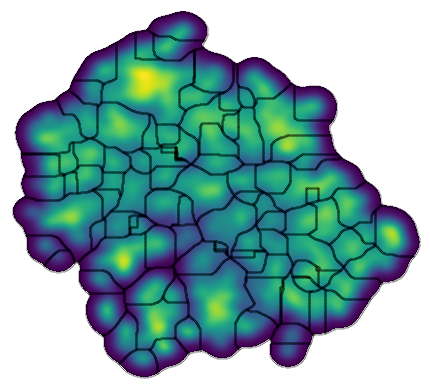

In [22]:
from neuroposelib.embed import Watershed
# Watershed clustering
data_obj.ws = Watershed(
    sigma=config["single_embed"]["sigma"], max_clip=1, log_out=True, pad_factor=0.05
)
data_obj.data["Cluster"] = data_obj.ws.fit_predict(data=data_obj.embed_vals)

# Plot density
vis.plot.density(
    data_obj.ws.density,
    data_obj.ws.borders,
    filepath=config["out_path"] + "/density.png",
    show=True,
)

Within the embedding, we can visualize the density of each animal separately.

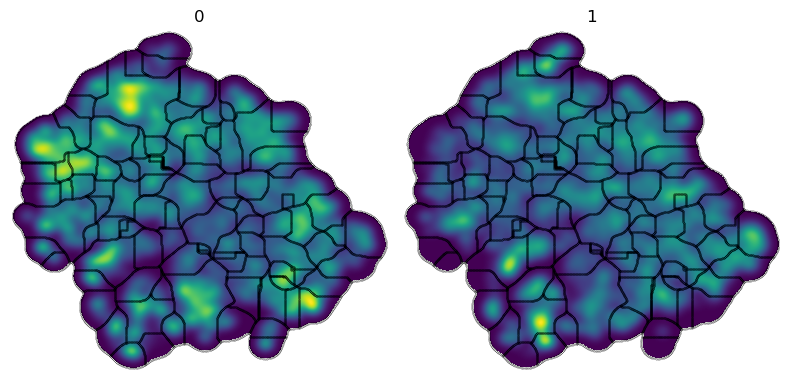

In [23]:
vis.plot.density_cat(
    data=data_obj,
    column="id",
    watershed=data_obj.ws,
    filepath=config["out_path"] + "/density_id.png",
    show=True,
)

We can also randomly sample some actions from each cluster. Videos will save in `neuroposelib/tutorials/results/tutorial/skeleton_vids/`

In [ ]:
vis.pose.sample_arena3D(
    pose_aligned,
    connectivity,
    labels=data_obj.data["Cluster"],
    n_samples=9,
    centered=True,
    VID_NAME = "cluster",
    N_FRAMES=100,
    fps=90,
    watershed=data_obj.ws,
    embed_vals=data_obj.embed_vals,
    filepath=config["out_path"],
)